In [1]:
!pip install librosa matplotlib IPython


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [21]:
!pip install soundfile


In [22]:
import librosa
from librosa import display
import numpy as np
import IPython.display as ipd
import matplotlib as plt
import soundfile as sf

In [11]:
# Load the audio file
y, sr = librosa.load('/content/aud2.wav', sr=None)

# Print the length of the audio in seconds
duration = librosa.get_duration(y=y, sr=sr)
print(f"Audio Duration: {duration} seconds")

# Calculate the start and end times for the segment (in seconds)
start_time = 0  # Choose a valid start time
end_time = min(20, duration)  # Choose a valid end time (e.g., 20 seconds or less if shorter)

# Convert times to sample indices
start_sample = int(start_time * sr)
end_sample = int(end_time * sr)

# Check if the segment is valid
if end_sample > len(y):
    print("The selected range is too long for the available audio data.")
else:
    # Play the audio segment
    ipd.Audio(data=y[start_sample:end_sample], rate=sr)


Audio Duration: 3.697392290249433 seconds


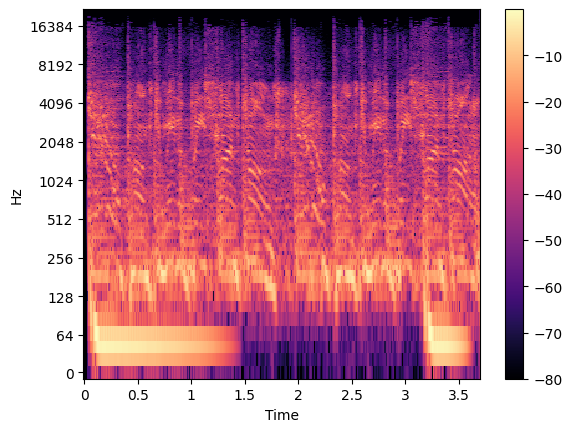

In [12]:
S_full, phase = librosa.magphase(librosa.stft(y))
idx = slice(*librosa.time_to_frames([90*110], sr=sr))
fig, ax = plt.pyplot.subplots()
img = display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

In [15]:
S_full = np.abs(librosa.stft(y))

# Determine the valid range for width
max_width = (S_full.shape[-1] - 1) // 2
print(f"Maximum valid width: {max_width}")

# Set width to slightly less than the maximum valid width
calculated_width = int(librosa.time_to_frames(2, sr=sr))
width = min(calculated_width, max_width - 1)  # Ensure width is strictly less than the max
print(f"Using width: {width}")

# Apply the nearest-neighbor filter with the adjusted width
S_filter = librosa.decompose.nn_filter(S_full, aggregate=np.median, metric='cosine', width=width)

# Ensure that the filter is within the bounds of the original spectrogram
S_filter = np.minimum(S_full, S_filter)

Maximum valid width: 159
Using width: 158


In [16]:
margin_i, margin_v = 3, 11
power = 3

mask_i = librosa.util.softmask(S_filter, margin_i * (S_full - S_filter), power=power)
mask_v = librosa.util.softmask(S_full - S_filter, margin_v * S_filter, power=power)

S_foreground = mask_v * S_full
S_background = mask_i * S_full

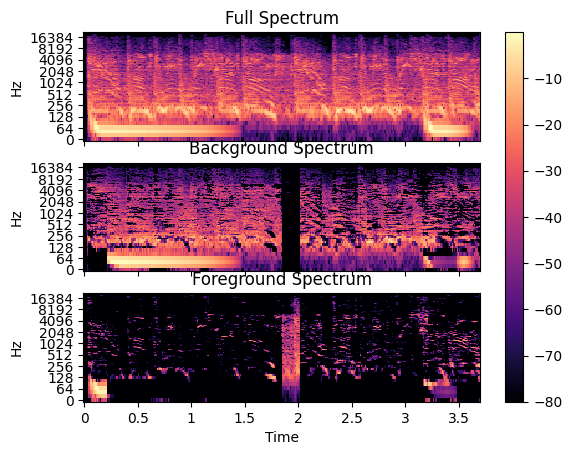

In [17]:
fig, ax = plt.pyplot.subplots(nrows=3, sharex=True, sharey=True)
img = display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full Spectrum')
ax[0].label_outer()

display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background Spectrum')
ax[1].label_outer()

display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground Spectrum')
ax[2].label_outer()

fig.colorbar(img, ax=ax)

In [19]:
y_foreground = librosa.istft(S_foreground * phase)
ipd.Audio(data=y_foreground[start_sample:end_sample], rate=sr)

In [23]:
# Define the file path where you want to save the audio
output_file = 'output_foreground.wav'

# Save the audio data to a .wav file
sf.write(output_file, y_foreground, sr)